# 0. Setup

In [41]:
# File System and Path Handling
import os
import pathlib

# Data Manipulation
import pandas as pd

# Preprocessing Tools
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Machine Learning Models
from sklearn.ensemble import BaggingRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor

# Model Selection and Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Utility for Saving Models
import joblib

# Visualization
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Download latest version
path = kagglehub.dataset_download("yasserh/loan-default-dataset")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/yasserh/loan-default-dataset/versions/1


In [ ]:
# Set the target directory for storing the specific CSV file
target_dir = "/Users/giliamo/code/YannAll/automated_loan_review_project/raw_data"
csv_file_name = "Loan_Default.csv"
csv_file_path = os.path.join(target_dir, csv_file_name)

# Check if the file already exists in the target directory
if os.path.exists(csv_file_path):
    print(f"File '{csv_file_name}' already exists. Using the local file.")
else:
    # Download latest version
    path = kagglehub.dataset_download("yasserh/loan-default-dataset")
    print("Path to dataset files:", path)

    # Create the target directory if it does not exist
    os.makedirs(target_dir, exist_ok=True)

    # Move the CSV file to the target directory
    shutil.move(os.path.join(path, csv_file_name), csv_file_path)
    print(f"CSV file has been moved to: {csv_file_path}")

# Load the CSV file
data = pd.read_csv(csv_file_path)
print("CSV file loaded successfully.")

File 'Loan_Default.csv' already exists. Using the local file.
CSV file loaded successfully.


In [ ]:
data.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


# 1. Explore Data

In [ ]:
# Display basic information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

In [ ]:
# Summary statistics for numerical columns
data.describe()

,ID,year,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,Status,dtir1
count,148670.000000,148670.0,1.486700e+05,112231.000000,112031.000000,109028.000000,148629.000000,1.335720e+05,139520.000000,148670.000000,133572.000000,148670.000000,124549.000000
mean,99224.500000,2019.0,3.311177e+05,4.045476,0.441656,3224.996127,335.136582,4.978935e+05,6957.338876,699.789103,72.746457,0.246445,37.732932
std,42917.476598,0.0,1.839093e+05,0.561391,0.513043,3251.121510,58.409084,3.599353e+05,6496.586382,115.875857,39.967603,0.430942,10.545435
min,24890.000000,2019.0,1.650000e+04,0.000000,-3.638000,0.000000,96.000000,8.000000e+03,0.000000,500.000000,0.967478,0.000000,5.000000
25%,62057.250000,2019.0,1.965000e+05,3.625000,0.076000,581.490000,360.000000,2.680000e+05,3720.000000,599.000000,60.474860,0.000000,31.000000
50%,99224.500000,2019.0,2.965000e+05,3.990000,0.390400,2596.450000,360.000000,4.180000e+05,5760.000000,699.000000,75.135870,0.000000,39.000000
75%,136391.750000,2019.0,4.365000e+05,4.375000,0.775400,4812.500000,360.000000,6.280000e+05,8520.000000,800.000000,86.184211,0.000000,45.000000
max,173559.000000,2019.0,3.576500e+06,8.000000,3.357000,60000.000000,360.000000,1.650800e+07,578580.000000,900.000000,7831.250000,1.000000,61.000000


In [ ]:
data.shape

(148670, 34)

# 2. Missing Values

## 2.1 Understanding Missing Values

In [ ]:
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100

# Missing values summary
missing_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_percentage
})

# Filter to show only columns with at least 1 missing value and sort
missing_summary = missing_summary[missing_summary['Missing Values'] > 0].sort_values(by='Percentage (%)', ascending=False)

print(missing_summary)

                           Missing Values  Percentage (%)
Upfront_charges                     39642       26.664425
Interest_rate_spread                36639       24.644515
rate_of_interest                    36439       24.509989
dtir1                               24121       16.224524
property_value                      15098       10.155378
LTV                                 15098       10.155378
income                               9150        6.154571
loan_limit                           3344        2.249277
approv_in_adv                         908        0.610749
age                                   200        0.134526
submission_of_application             200        0.134526
loan_purpose                          134        0.090133
Neg_ammortization                     121        0.081388
term                                   41        0.027578


In [ ]:
# Variable with column names that have missing values
columns_with_missing_values = missing_summary.index.tolist()

print(columns_with_missing_values)

['Upfront_charges', 'Interest_rate_spread', 'rate_of_interest', 'dtir1', 'property_value', 'LTV', 'income', 'loan_limit', 'approv_in_adv', 'age', 'submission_of_application', 'loan_purpose', 'Neg_ammortization', 'term']


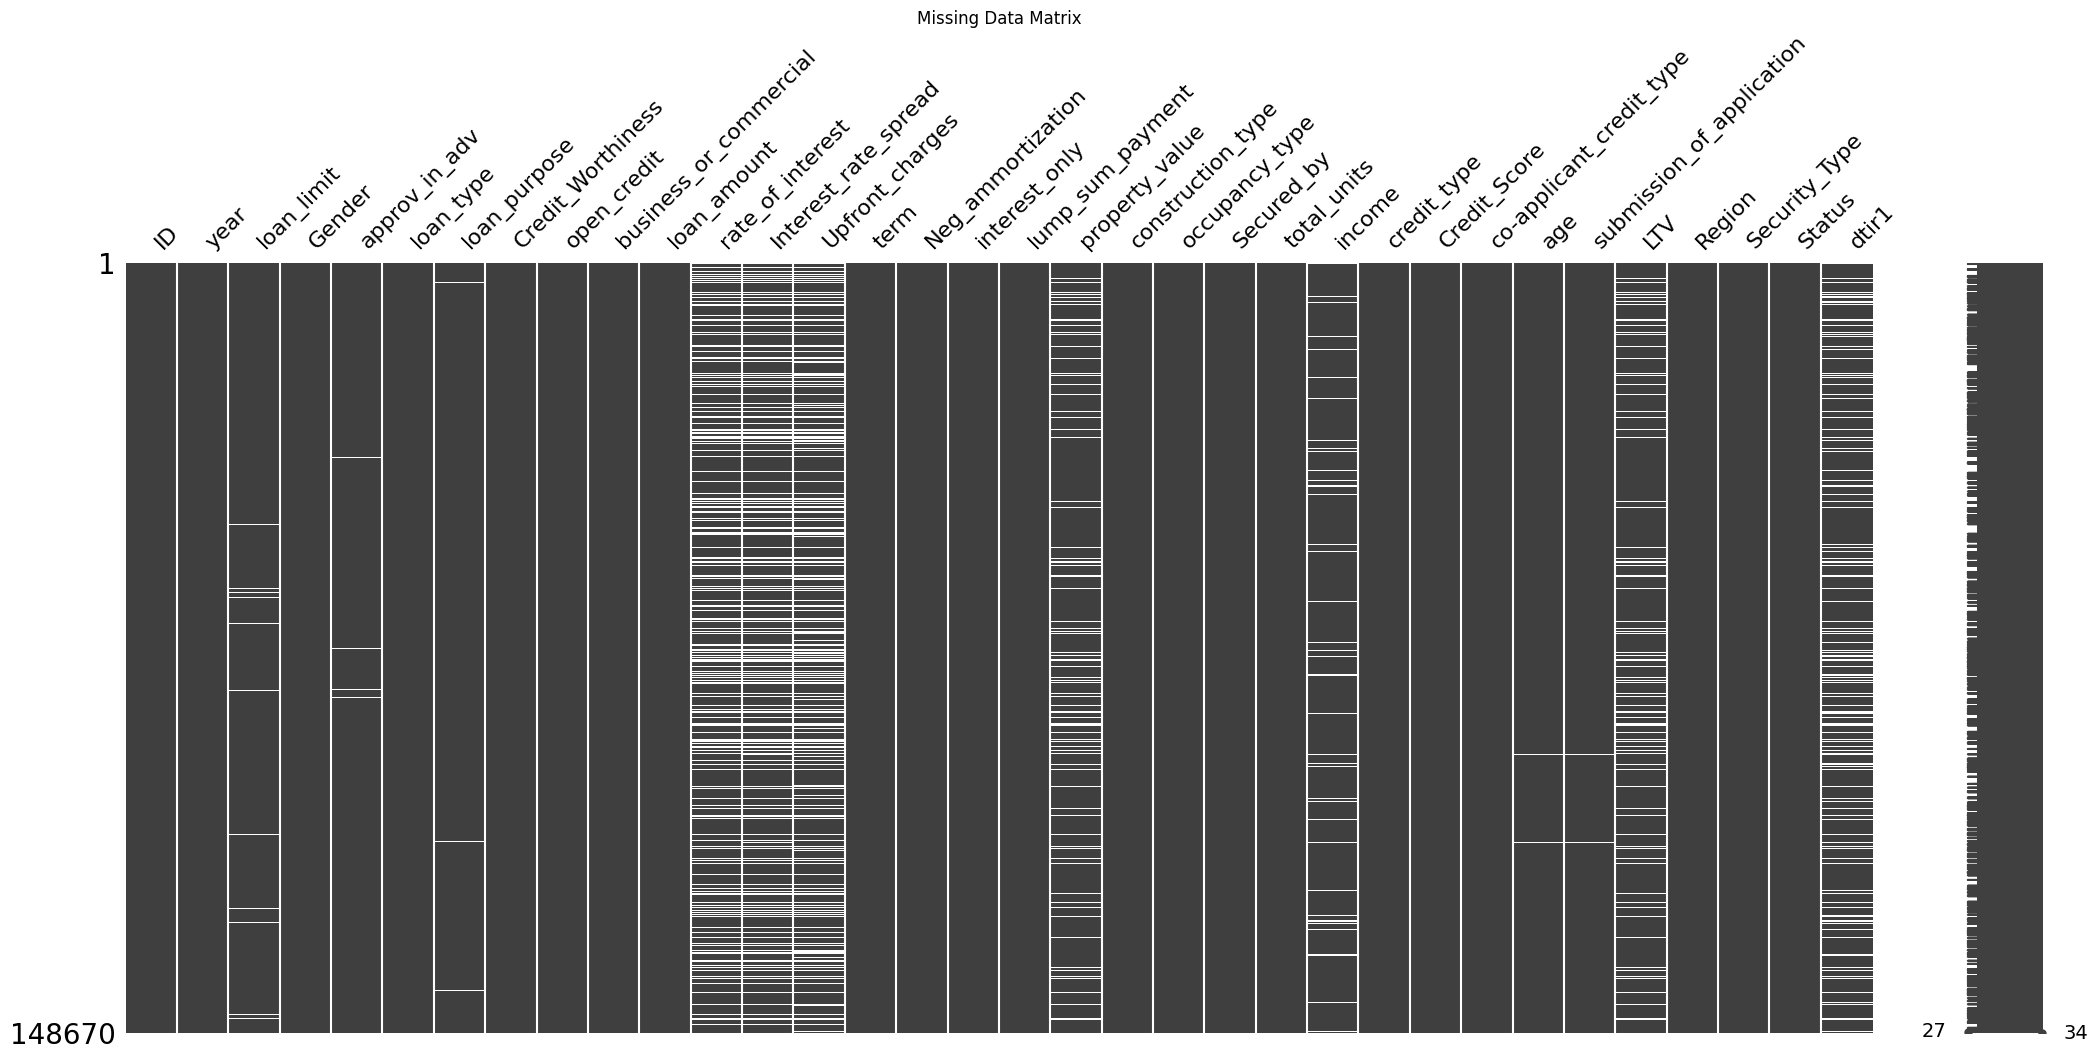

In [ ]:
msno.matrix(data)
plt.title("Missing Data Matrix")
plt.show()

**Intention**: The matrix is used to visualize which columns and rows have missing data, giving a quick overview of the extent and distribution of missing values.


**Interpretation**: In the matrix, white lines represent missing values. The plot shows several columns with a substantial number of missing values (e.g., Upfront_charges, Interest_rate_spread). Identifying these columns is critical to plan the appropriate imputation strategies.

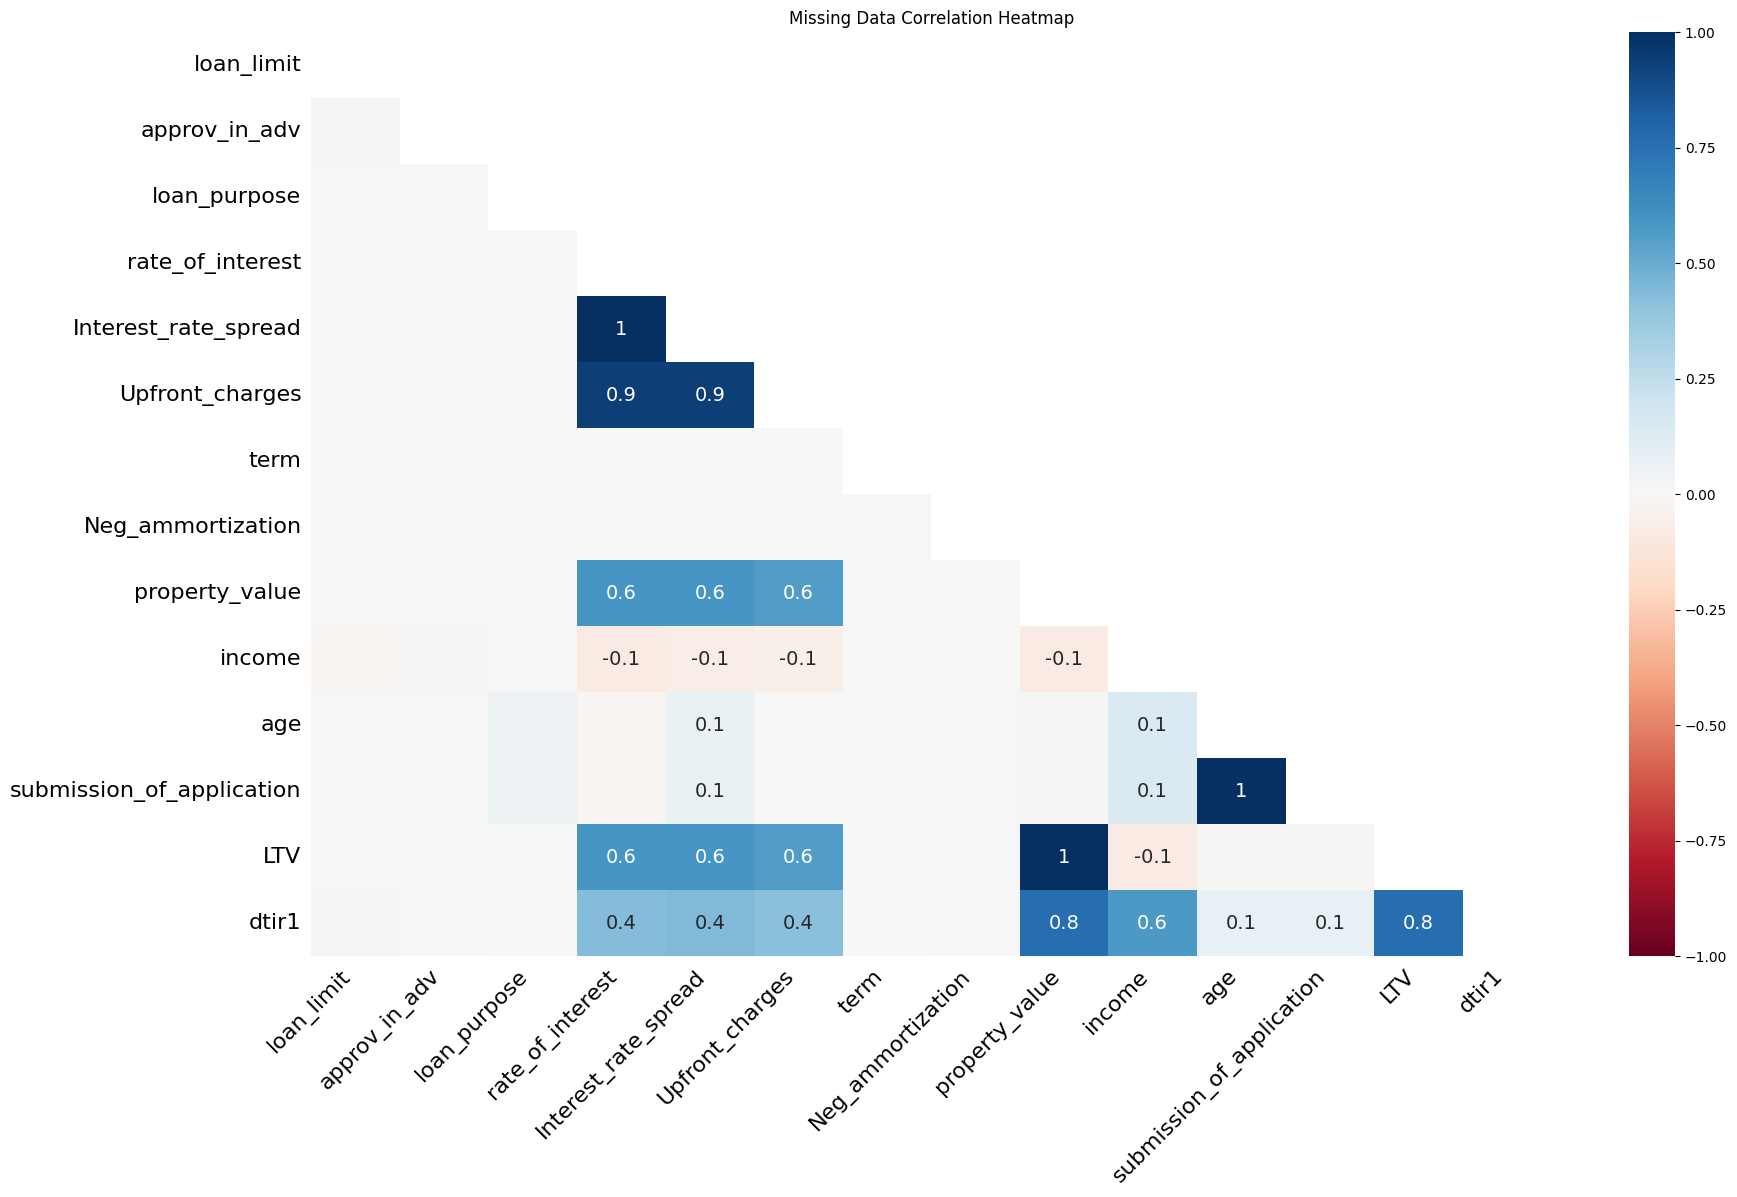

In [ ]:
msno.heatmap(data)
plt.title("Missing Data Correlation Heatmap")
plt.show()

**Intention**: The correlation heatmap helps in understanding whether the missing values are correlated between different features. If there is a high correlation, it suggests that the missing values in one column are related to the missing values in another.


**Interpretation**: The heatmap reveals that features like `Upfront_charges`, `Interest_rate_spread`, and `rate_of_interest` have a high correlation in missing values. This suggests that their absence might be related. Understanding these relationships can help determine if missingness can be inferred or replaced conditionally.

<Axes: >

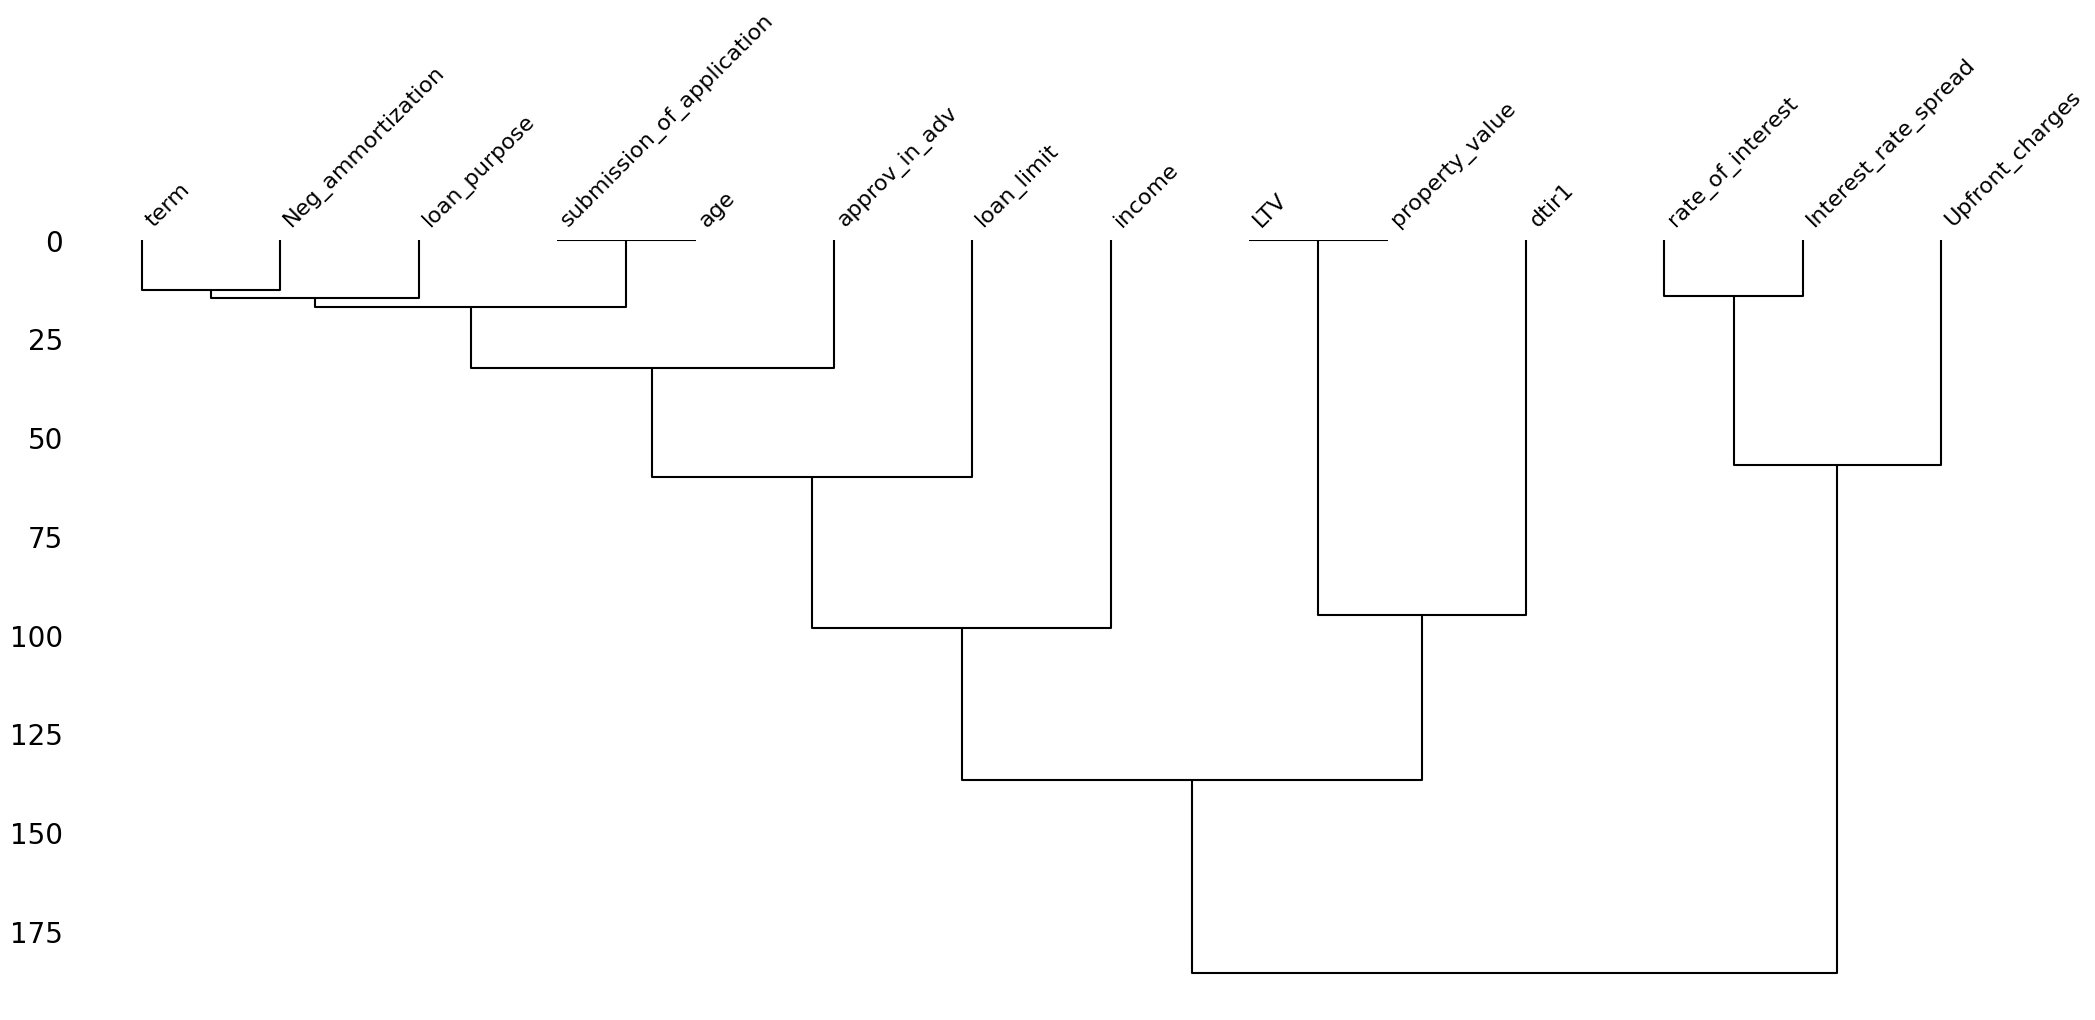

In [ ]:
msno.dendrogram(data[columns_with_missing_values])

**Intention**: A dendrogram shows hierarchical clustering of columns with missing values, helping to identify clusters of features that share similar missingness patterns.


**Interpretation**: The dendrogram shows the hierarchical relationships between the missing value patterns in different columns. Columns that are closely linked in the dendrogram, such as `Upfront_charges`, `Interest_rate_spread`, and `rate_of_interest`, have similar patterns of missing values, which implies a possible shared reason for their absence.


Columns that merge lower in the dendrogram have a stronger connection in terms of missing data. This clustering suggests that we may consider applying the same imputation strategy or investigating related causes for these missing values. For example, `income`, `LTV`, and `property_value` could potentially be imputed using related approaches due to their close linkage.

## 2.2 Handling Missing Values

### 2.2.1 Deletion of Data

In [ ]:
# Create a copy of the dataset to work with
df_temp = data.copy()

# Set the threshold for deletion of attributes
ATTRIBUTE_THRESHOLD = 25  # % of missing values

# Calculate the percentage of missing values per column
missing_percentage = df_temp.isnull().sum() / len(df_temp) * 100

# Drop attributes with missing values percentage greater than the threshold
for col, per in missing_percentage.items():
    if per > ATTRIBUTE_THRESHOLD:
        df_temp.drop(col, axis=1, inplace=True)

# Display the updated DataFrame information
print(df_temp.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 33 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  term                       14

**Intention**: The goal of deleting attributes with high missing values is to reduce the complexity of the dataset by removing columns that may not provide reliable information due to excessive missing values. This helps to ensure that our model only works with meaningful features, reducing noise and potential biases.


**Interpretation**: We set a threshold of 25% for missing values and deleted any columns exceeding this limit. This is effective when the percentage of missing data is too high for reliable imputation, thus enhancing dataset quality and ensuring better model performance.

In [ ]:
# After attribute deletion, let's check which columns still have missing values

# Calculate the number and percentage of missing values for the modified dataset
missing_values = df_temp.isnull().sum()
missing_percentage = (missing_values / len(df_temp)) * 100

# Create a summary of missing values
missing_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_percentage
})

# Filter to show only columns with at least 1 missing value and sort by percentage
missing_summary = missing_summary[missing_summary['Missing Values'] > 0].sort_values(by='Percentage (%)', ascending=False)

# Print the summary of columns with missing values after attribute deletion
print(missing_summary)


                           Missing Values  Percentage (%)
Interest_rate_spread                36639       24.644515
rate_of_interest                    36439       24.509989
dtir1                               24121       16.224524
property_value                      15098       10.155378
LTV                                 15098       10.155378
income                               9150        6.154571
loan_limit                           3344        2.249277
approv_in_adv                         908        0.610749
age                                   200        0.134526
submission_of_application             200        0.134526
loan_purpose                          134        0.090133
Neg_ammortization                     121        0.081388
term                                   41        0.027578


### 2.2.2 Deletion of Samples

In [ ]:
# Create a copy of the dataset to work with
df_temp = data.copy()

# Get the missing count of each sample
for idx in range(df_temp.shape[0]):
    df_temp.loc[idx, 'missing_count'] = df_temp.iloc[idx, :].isnull().sum()

# Set the threshold to remove samples having missing values in more than 5 attributes
SAMPLE_THRESHOLD = 5

print("Samples Before Removal: {}".format(df_temp.shape[0]))

# Remove samples with missing values in more than the threshold
df_temp.drop(df_temp[df_temp['missing_count'] > SAMPLE_THRESHOLD].index, axis=0, inplace=True)

print("Samples After Removal: {}".format(df_temp.shape[0]))

Samples Before Removal: 148670
Samples After Removal: 132360


**Intention**: After dropping attributes with a high percentage of missing values, it’s important to verify the remaining columns to identify which still contain missing data. This helps in planning the next steps for data handling.

Interpretation: The result indicates that the original dataset had 148,670 samples (rows), and after removing samples with missing values in more than 5 attributes, the number of samples was reduced to 132,360. This means 16,310 samples were removed due to having too many missing values.


This step improves data quality by ensuring that only samples with sufficient information remain, making the dataset more reliable for analysis and reducing the risk of poor model performance due to excessive missing data.

In [ ]:
# After sample deletion, let's check which columns still have missing values

# Calculate the number and percentage of missing values for the modified dataset
missing_values = df_temp.isnull().sum()
missing_percentage = (missing_values / len(df_temp)) * 100

# Create a summary of missing values
missing_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_percentage
})

# Filter to show only columns with at least 1 missing value and sort by percentage
missing_summary = missing_summary[missing_summary['Missing Values'] > 0].sort_values(by='Percentage (%)', ascending=False)

# Print the summary of columns with missing values after sample deletion
print(missing_summary)

                      Missing Values  Percentage (%)
Upfront_charges                23485       17.743276
rate_of_interest               20329       15.358870
Interest_rate_spread           20329       15.358870
income                          7921        5.984436
dtir1                           7811        5.901330
loan_limit                      2956        2.233303
approv_in_adv                    809        0.611212
Neg_ammortization                113        0.085373
loan_purpose                     109        0.082351
term                              29        0.021910
property_value                     2        0.001511
LTV                                2        0.001511


### 2.2.3 Encoding Categorical Variables

We use the encoder for the categorical features because many machine learning models can only work with numerical data. Categorical variables, such as gender, education level or region, are not directly numeric and therefore need to be converted into a numeric form.


One-hot encoding converts each category into a separate binary variable so that models can correctly interpret the differences between categories without creating implicit rankings or distances that could arise with numerical encoding such as label encoding.

In [ ]:
#Encode categorical variables to prepare them for imputation methods.

from sklearn.preprocessing import OneHotEncoder

# Get categorical columns with missing values
missing_columns = data.columns[data.isnull().any()]
cat_missing_cols = [col for col in missing_columns if data[col].dtype == 'object']

# Initialize the encoder
encoder = OneHotEncoder(handle_unknown='ignore')

# Fit and transform categorical columns
encoded_data = encoder.fit_transform(data[cat_missing_cols])

# Convert the sparse matrix to a DataFrame
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(cat_missing_cols))

# Drop original categorical columns and concatenate the encoded data
data = data.drop(cat_missing_cols, axis=1)
data = pd.concat([data.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

print("Categorical variables encoded successfully.")

Categorical variables encoded successfully.


### 2.2.4 Nearest Neighbors (KNN) Imputation

**Intention**: Use KNN to impute missing values by finding similar data points and averaging their values. This works well when data points are close together.

In [ ]:
from sklearn.impute import KNNImputer

# Selecting numerical columns for KNN Imputation
num_cols = [col for col in data.columns if data[col].dtype in ['int64', 'float64']]

# Initializing KNN Imputer
knn_imputer = KNNImputer(n_neighbors=3)

# Fit and transform the data
data[num_cols] = knn_imputer.fit_transform(data[num_cols])

print("KNN Imputation completed successfully.")

KNN Imputation completed successfully.


### 2.2.5 Tree Based Imputation

**Intention**: Tree-based imputation uses decision trees trained with complete data to predict the missing values based on other available variables. This is a particularly useful method as decision trees are good at dealing with non-linear and complex data structure.

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor

# Make a copy of the data for tree-based imputation
tree_data = data.copy()

# Define columns with missing values
missing_cols = [col for col in tree_data.columns if tree_data[col].isnull().sum() > 0]
non_missing_cols = [col for col in tree_data.columns if tree_data[col].isnull().sum() == 0]

# Loop over each column with missing values
for col in missing_cols:
    # Define a Bagging Regressor with DecisionTree as the base model
    model = BaggingRegressor(DecisionTreeRegressor(), n_estimators=40, max_samples=1.0, max_features=1.0, bootstrap=False, n_jobs=-1)

    # Split data into samples with and without missing values for the current column
    col_missing = tree_data[tree_data[col].isnull()]
    col_not_missing = tree_data.dropna(subset=[col])

    # Define the training and prediction datasets
    X_train = col_not_missing[non_missing_cols]
    y_train = col_not_missing[col]
    X_predict = col_missing[non_missing_cols]

    # Fit the model and predict the missing values
    model.fit(X_train, y_train)
    predicted_values = model.predict(X_predict)

    # Replace the missing values with predictions
    tree_data.loc[col_missing.index, col] = predicted_values

print("Tree-based imputation completed successfully.")


Tree-based imputation completed successfully.


In [ ]:
# Calculate the number and percentage of missing values for the modified dataset
missing_values = tree_data.isnull().sum()
missing_percentage = (missing_values / len(tree_data)) * 100

# Create a summary of missing values
missing_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_percentage
})

# Filter to show only columns with at least 1 missing value and sort by percentage
missing_summary = missing_summary[missing_summary['Missing Values'] > 0].sort_values(by='Percentage (%)', ascending=False)

# Print the summary of columns with missing values after tree-based imputation
print(missing_summary)

Empty DataFrame
Columns: [Missing Values, Percentage (%)]
Index: []


# 3. Save Data

In [ ]:
# Save the data as a CSV file in the current directory
csv_file_path = "loan_data_no_missing_values.csv"
tree_data.to_csv(csv_file_path, index=False)

# Provide a link to download the file
from google.colab import files
files.download(csv_file_path)

print(f"File saved successfully as {csv_file_path} and ready for download.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File saved successfully as loan_data_no_missing_values.csv and ready for download.


This step saves the cleaned dataset as a CSV file so it can be easily reloaded for future use, bypassing the need to repeat previous data cleaning and preprocessing steps. This approach saves time and computational resources, especially when multiple analyses or models need to be run on the cleaned data. By storing the preprocessed data, you create a checkpoint that allows you to move directly to the next analysis steps without having to redo the entire preprocessing pipeline every time.

In [36]:
from pathlib import Path

# Define the path to save the CSV file
base_dir = Path("/Users/giliamo/code/YannAll/automated_loan_review_project/raw_data")
csv_file_path = base_dir / "loan_data_no_missing_values.csv"

# Save the data to the specified path
tree_data.to_csv(csv_file_path, index=False)

print(f"File saved successfully to {csv_file_path}")


File saved successfully to /Users/giliamo/code/YannAll/automated_loan_review_project/raw_data/loan_data_no_missing_values.csv


# 4. Create Preprocesor

In [42]:
# Define the categorical and numerical columns
categorical_features = data.select_dtypes(include=['object']).columns.tolist()
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create the transformer for numerical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with the mean
    ('scaler', StandardScaler())  # Standardize numerical columns
])

# Create the transformer for categorical columns
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # One-Hot-Encoding for categorical variables
])

# Combine both transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Fit and transform the data using the preprocessor
transformed_data = preprocessor.fit_transform(data)

# Get the feature names after transformation
# Numerical feature names remain the same
# Categorical feature names are expanded through OneHot-Encoding
transformed_columns = numerical_features + list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features))

# Create a new DataFrame with the transformed data
transformed_df = pd.DataFrame(transformed_data, columns=transformed_columns)


In [44]:
transformed_df

,ID,year,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,...,credit_type_EQUI,credit_type_EXP,co-applicant_credit_type_CIB,co-applicant_credit_type_EXP,Region_North,Region_North-East,Region_central,Region_south,Security_Type_Indriect,Security_Type_direct
0,-1.732039,0.0,-1.166980,0.333242,1.082005,0.099479,0.425803,-1.055655,-0.816426,0.502357,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,-1.732016,0.0,-0.677607,-0.056684,0.483747,-0.860201,0.425803,-0.596379,-0.308948,-1.275413,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2,-1.731993,0.0,0.409890,1.014820,-0.485338,-0.848027,0.425803,0.040984,0.395884,1.158234,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,-1.731969,0.0,0.681764,0.425176,0.490237,-1.006662,0.425803,0.462769,0.771794,-0.973365,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,-1.731946,0.0,1.986759,-0.050344,-0.273997,-1.048639,0.425803,0.743958,0.546248,-0.843916,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148665,1.731946,0.0,0.573014,-1.714663,-0.369527,2.309508,-2.655928,0.322174,0.142145,-0.352008,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
148666,1.731969,0.0,1.388636,2.213130,0.841931,-1.048639,0.425803,0.828315,0.029372,-1.128704,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
148667,1.731993,0.0,0.627389,-1.714663,-0.725480,-0.635061,-2.655928,0.659601,-0.008219,0.019080,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
148668,1.732016,0.0,-0.731981,-1.001384,0.290254,0.409029,-2.655928,-0.605752,0.029372,0.321128,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


In [46]:
# Check for columns that do not have the dtype 'float64'
non_float64_columns = transformed_df.select_dtypes(exclude=['float64']).dtypes

if not non_float64_columns.empty:
    print("Columns with data types other than float64:")
    print(non_float64_columns)
else:
    print("All columns are of type float64.")

All columns are of type float64.


# 5. Building and Evaluating the Machine Learning Model

**Next Steps:**

1.   Split the Data: To evaluate generalization capability.
2.   Train a Model: To learn patterns in the training data.
3.   Evaluate the Model: To understand how well the model generalizes.
4.   Hyperparameter Tuning: To improve model performance and robustness.
5.   Save the Model: To reuse it without retraining, especially for deployment.
6.   Feature Importance Analysis: To identify which features have the most impact on predictions.







**Step 1**: Split the Data into Training and Test Sets

In [53]:
# Define the target column for predicting loan defaults
target_column = 'Status'

# Define features and target
X = transformed_df.drop(columns=[target_column])  # Features
y = transformed_df[target_column]  # Target

In [54]:
# Ensure the target column is treated as categorical (binary: 0 or 1)
y = transformed_df[target_column].astype(int)

**Intention**: The astype(int) converts the target column to integer values to ensure that Status is interpreted correctly by the classifier. This way, the model knows that it is dealing with a binary classification problem (loan default or not).

In [55]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Step 2**: Select and Train a Random Forest Classifier

In [56]:
# Initialize the model
model = RandomForestClassifier(random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)

print("✅ Model training completed.")


✅ Model training completed.


**Intention**: A Random Forest Classifier is chosen because it is well-suited for tabular data with both categorical and numerical features, and it can handle complex patterns well. Training the model helps it learn relationships between the features and the target variable. Unlike Logistic Regression, which assumes linear relationships, Random Forest can capture non-linear patterns and interactions, making it more powerful for complex datasets.

**Step 3**: Evaluate the Model Performance

In [57]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.2f}")

# Print a classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print a confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Model accuracy: 0.92

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     22494
           1       0.95      0.69      0.80      7240

    accuracy                           0.92     29734
   macro avg       0.93      0.84      0.87     29734
weighted avg       0.92      0.92      0.91     29734


Confusion Matrix:
[[22224   270]
 [ 2216  5024]]


**Interpretation**: The model's accuracy is 92%, which is good overall. However, while the precision for identifying defaults (class 1) is high (95%), the recall is relatively low (69%). This means the model correctly identifies most predicted defaults, but misses a significant number of actual defaults, resulting in false negatives.


The confusion matrix shows 2,216 default cases were classified as non-defaults, indicating the model struggles to catch all defaults. Improving recall for defaults could help reduce these false negatives.

**Step 4**: Hyperparameter Tuning Using Grid Search

In [59]:
from sklearn.model_selection import GridSearchCV

# Define a grid of hyperparameters
param_grid = {
    'n_estimators': [100, 200],  # Reduced number of values to speed up computation
    'max_depth': [None, 10],  # Reduced number of values to reduce complexity
    'min_samples_split': [5],  # Using a single value to limit combinations
}

# Initialize GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)  # Reduced cross-validation to 3-fold to save time

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.2f}")

Best hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation score: 0.91


**Interpretation**: Overall, the model appears to have a strong performance with the given hyperparameters, capturing relationships in the data while mitigating overfitting risks with the chosen parameter values. The cross-validation score shows that the model generalizes well, but it may be worth testing on a separate test set to confirm this performance.

**Step 5**: Make Predictions on the Test Set (with Optimized Model)

In [60]:
# Make predictions using the best model found by GridSearchCV
best_model = grid_search.best_estimator_
y_pred_optimized = best_model.predict(X_test)

# Calculate accuracy for the optimized model
optimized_accuracy = accuracy_score(y_test, y_pred_optimized)
print(f"Optimized Model Accuracy: {optimized_accuracy:.2f}")

# Print a classification report for the optimized model
print("\nOptimized Classification Report:")
print(classification_report(y_test, y_pred_optimized))

# Print a confusion matrix for the optimized model
print("\nOptimized Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_optimized))

Optimized Model Accuracy: 0.92

Optimized Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     22494
           1       0.95      0.70      0.80      7240

    accuracy                           0.92     29734
   macro avg       0.93      0.84      0.88     29734
weighted avg       0.92      0.92      0.91     29734


Optimized Confusion Matrix:
[[22232   262]
 [ 2194  5046]]


**Interpretation**: The optimized model is very good at identifying non-default cases but could be improved to better identify default cases.
Given the critical nature of correctly identifying defaults in the loan context, focusing on improving recall for class 1 is crucial.

**Step 6**: Save the Trained Model for Future Use

In [61]:
import joblib

# Save the trained model
joblib.dump(best_model, 'loan_default_model.pkl')
print("✅ Model saved successfully.")

✅ Model saved successfully.


Step 7: Feature Importance Analysis

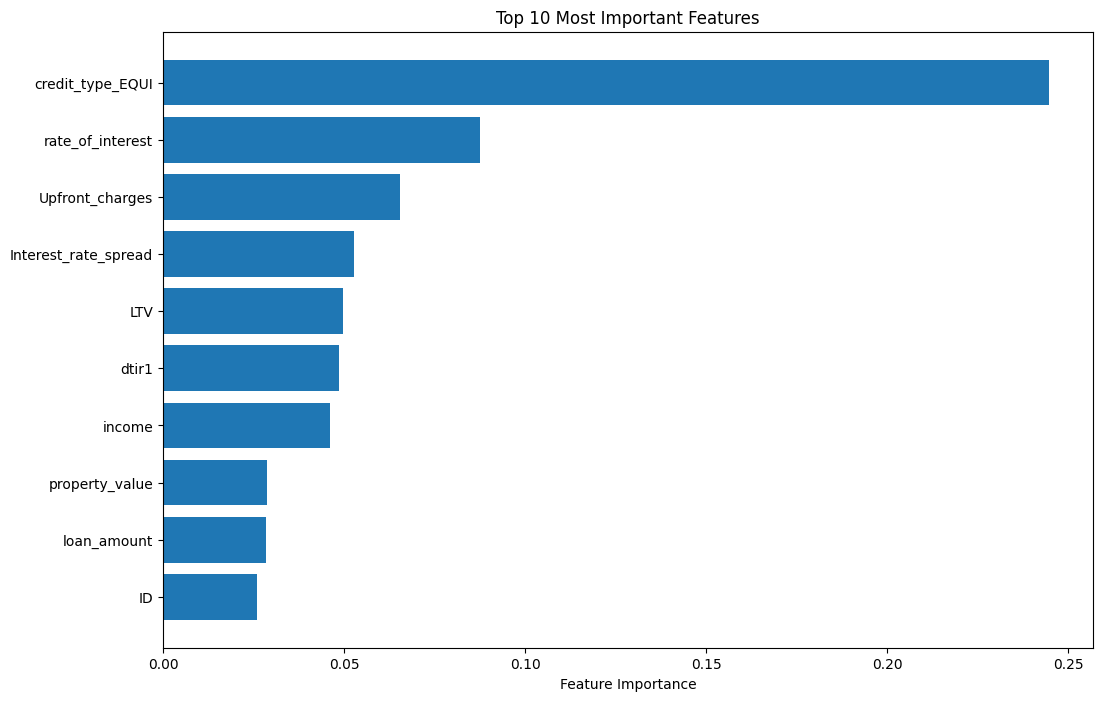

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances from the best model
feature_importances = best_model.feature_importances_

# Create a sorted list of feature importances and corresponding feature names
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_features = [X.columns[i] for i in sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(sorted_features[:10], sorted_importances[:10], align='center')
plt.xlabel('Feature Importance')
plt.title('Top 10 Most Important Features')
plt.gca().invert_yaxis()
plt.show()

**Interpretation**: Credit-related features like `credit_type` and `rate_of_interest` are highly predictive, suggesting that credit history and loan terms are major indicators of default risk.
Financial metrics such as `income`, `LTV`, and `debt-to-income ratio` are also critical for evaluating a borrower's ability to repay.